In [64]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [53]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data # the data (number) stored in the node
    self.grad = 0.0 # initialize the gradient to 0
    self._backward = lambda: None # input nodes can't go backwards (I think that's what this means)
    self._prev = set(_children) # set the children of the node (I think for drawing, maybe more advanced stuff too)
    self._op = _op # operation that created this node
    self.label = label # label for display

  # string representation
  def __repr__(self):
    return f"Value(data={self.data})"
  
  # add two nodes (or node + number)
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # if other isn't a value node, make it one
    out = Value(self.data + other.data, (self, other), '+') # resulting node
    
    # back propagate using chain rule for addition
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
        
    # set the backward function for this node
    out._backward = _backward
    
    return out

  # multiply two nodes (or node + number)
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    # back propagate using chain rule for multiplication
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  # power function (node + number only)
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}') # new node is Value.data^n

    # chain rule for power (n * x ^ (n-1)) * parent gradient
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  # support for num * Value and not just Value * num
  def __rmul__(self, other): # other * self
    return self * other

  # fancy way to do division
  def __truediv__(self, other): # self / other
    return self * other**-1

  # negating a value
  def __neg__(self): # -self
    return self * -1

  # fancy subtraction
  def __sub__(self, other): # self - other
    return self + (-other)

  # support for num + Value
  def __radd__(self, other): # other + self
    return self + other

  # special function with limit +/- 1
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # math expression of tanh
    out = Value(t, (self, ), 'tanh')
    
    # chain rule tanh derivative
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  # square function
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  # to back propogate
  def backward(self):
    
    # first, order the graph (must be DAG) using a topo sort
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    # then call the backward function on each node
    self.grad = 1.0
    for node in reversed(topo):
      node._backward() #input/leaf nodes will have no function so nothing will happen for them

In [27]:
# display code
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [54]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

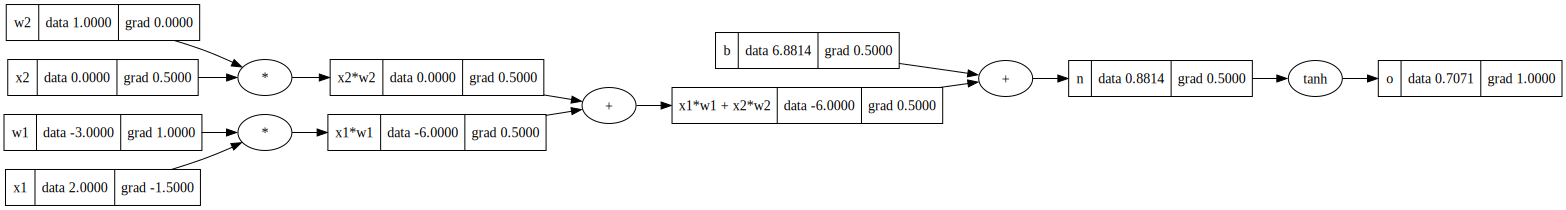

In [56]:
draw_dot(o)

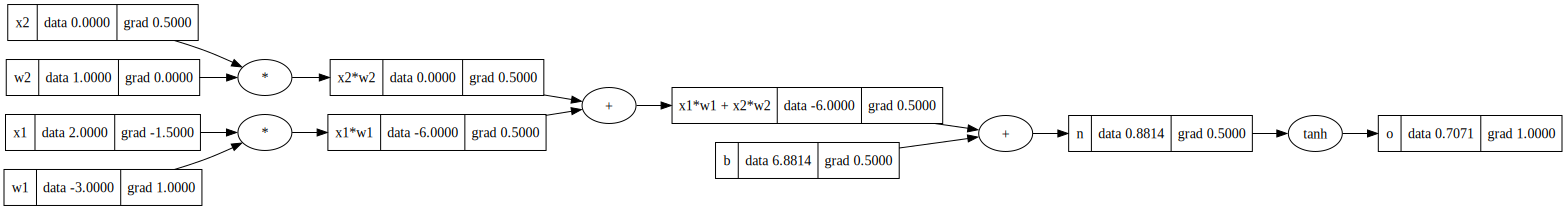

In [60]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

In [69]:
class Neuron:
  # start the neuron off with some random weights and biases
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  # calling the neuron with an input vector (what happens when you call var(x) if var = Neuron(n))
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # mutltiply each item in the input vector by the corresponding weight and sum them
    out = act.tanh() # activation function
    return out
  
  # list all the Value nodes (weights) in this Neuron, including the bias
  def parameters(self):
    return self.w + [self.b]

class Layer:
  # a layer creates nout # of Neurons each with nin input variables
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  # calling a layer returns a list of the output of all the neruons (of which there are nout)
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: # Multi Layered Perceptron
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts # create a list from the nins and nouts
    
    # this creates a list of layers where each layer has sz[i] input values and sz[i + 1] Neurons
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    # pass x successively through the layers. since it updates each time, the output value from one layer is the input for the next
    # the result of calling layers is a list of values, and since we made the number of output values for each layer the number of inputs for the successive layer, we never have mismatches in numbers between layers
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

n = MLP(3, [4, 4, 1])

In [72]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [75]:
# gradient descent - make a bunch of passes over the NN, each time nudging the data in each neuron in the direction that decreases the loss function
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass, don't forget to zero out the gradients each time
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.00841022444300241
1 0.008195506243840928
2 0.007990992001268418
3 0.007795983161281741
4 0.00760984300044895
5 0.007431989963253197
6 0.007261891840563704
7 0.0070990606680936316
8 0.00694304824322336
9 0.006793442174620076
10 0.006649862392341031
11 0.006511958057099171
12 0.006379404816518089
13 0.006251902363844972
14 0.006129172260996841
15 0.006010955993203378
16 0.005897013227057039
17 0.005787120247630963
18 0.0056810685535925885
19 0.005578663592025185


In [76]:
ypred

[Value(data=0.9649544877157954),
 Value(data=-0.9723065441926716),
 Value(data=-0.9574696507629165),
 Value(data=0.957872603213798)]